This script is to check meridional projection. 

In [1]:
import sys
import numpy as np
import pandas as pd  
import xarray as xr 
import dask
from scipy import special
import math 
import matplotlib.pyplot as plt 

In [5]:
def projection(zmode=1, m=5, mflg='ex1', time_range=['1979-01-01','2019-12-31'], lat_range=[90, -90]):
    # zmode: the vertical mode, default m = 1
    # m: wave truncation
    # time_range: the time range of the data used in training and validating the model
    # lat_range: the latitude range (y) of the data used in projection

    # parameters
    N = 1e-2  # buoyancy frequency
    H = 1.6e4  # tropopause height
    beta= 2.28e-11  # variation of coriolis parameter with latitude
    g = 9.8  # gravity acceleration 
    theta0 = 300  # surface potential temperature
    c = N * H / np.pi / zmode # gravity wave speed
    L = np.sqrt(c / beta)  # horizontal scale 

    # read data
    fn = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/ERA5.olrGfltG.day.1901to2020.nc'
    ds = xr.open_dataset(fn)

    ds1 = ds.sel(time=slice(time_range[0], time_range[1]), lat=slice(lat_range[0], lat_range[1]))

    olr = ds1['olr'].values  # (time, lat, lon)
    lat = ds1['lat']
    lon = ds1['lon'].values
    time = ds1['time'].values

    # define y = lat * 110 km / L
    y = lat.values * 110 * 1000 / L # dimensionless

    # define meridianol wave structures
    phi = []

    if mflg=='odd':
        m_list = np.arange(1,m,2)
    elif mflg=='even':
        m_list = np.arange(0,m,2)
    elif mflg=='all':
        m_list = np.arange(m)
    elif mflg=='one':
        m_list = [m-1]
    elif mflg=='1pls':
        m_list = [0,m-1]
    elif mflg=='ex1':
        m_list = np.arange(1,m)
    else:
        print('wrong m flag!')
        exit()

    for i in m_list:
        p = special.hermite(i)
        Hm = p(y)
        phim = np.exp(- y**2 / 2) * Hm / np.sqrt((2**i) * np.sqrt(np.pi) * math.factorial(i))

        phi.append(np.reshape(phim, (1, len(y), 1)))

    # projection coefficients
    olrm = []

    dy = (lat[0].values - lat[1].values) * 110 * 1000 / L 

    for i in range(len(m_list)):
        um = np.sum(olr * phi[i] * dy, axis=1, keepdims=True)  # (time, 1, lon)
        olrm.append(um)

    # reconstruction 
    olr_re = np.zeros(np.shape(olr))  # (time, lat, lon)

    for i in range(len(m_list)):
        olr_re = olr_re + olrm[i] * phi[i]

    return olr_re, olrm, phi  # (time, m, lon)


In [6]:
olr_re, olrm, phi = projection(zmode=1, m=5, mflg='ex1', time_range=['1979-01-01','2019-12-31'], lat_range=[90, -90])

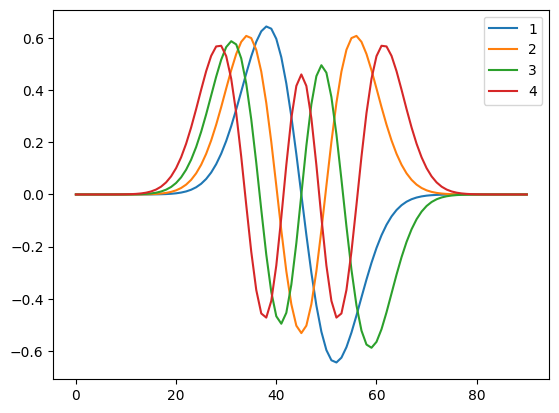

In [8]:
for i in np.arange(np.shape(phi)[0]):
    plt.plot(phi[i].squeeze(), label=str(i+1))
plt.legend()

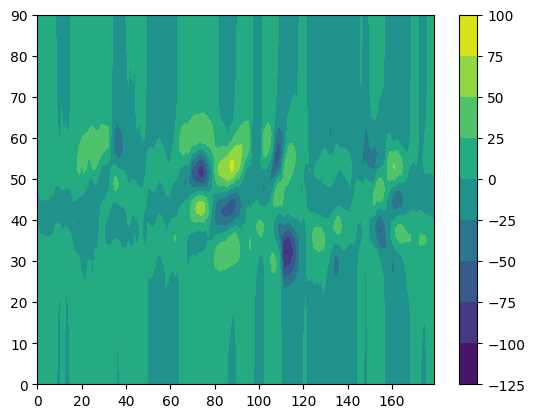

In [9]:
plt.contourf(olr_re[0,:,:].squeeze())
plt.colorbar()

In [14]:
# parameters
zmode = 1 
mflg='one'
time_range=['1979-01-01','2019-12-31']
lat_range=[90, -90]
N = 1e-2  # buoyancy frequency
H = 1.6e4  # tropopause height
beta= 2.28e-11  # variation of coriolis parameter with latitude
g = 9.8  # gravity acceleration 
theta0 = 300  # surface potential temperature
c = N * H / np.pi / zmode # gravity wave speed
L = np.sqrt(c / beta)  # horizontal scale 
print('L: ', L)
m = 2

# read data
fn = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/ERA5.olrGfltG.day.1901to2020.nc'
ds = xr.open_dataset(fn)

ds1 = ds.sel(time=slice(time_range[0], time_range[1]), lat=slice(lat_range[0], lat_range[1]))

olr = np.copy(olr_re)  # (time, lat, lon)
lat = ds1['lat']
lon = ds1['lon'].values
time = ds1['time'].values

# define y = lat * 110 km / L
y = lat.values * 110 * 1000 / L # dimensionless

# define meridianol wave structures
phi = []

if mflg=='odd':
    m_list = np.arange(1,m,2)
elif mflg=='even':
    m_list = np.arange(0,m,2)
elif mflg=='all':
    m_list = np.arange(m)
elif mflg=='one':
    m_list = [m-1]
else:
    print('wrong m flag!')
    exit()

for i in m_list:
    p = special.hermite(i)
    Hm = p(y)
    phim = np.exp(- y**2 / 2) * Hm / np.sqrt((2**i) * np.sqrt(np.pi) * math.factorial(i))

    phi.append(np.reshape(phim, (1, len(y), 1)))

# projection coefficients
olrm = []

dy = (lat[0].values - lat[1].values) * 110 * 1000 / L 

for i in range(len(m_list)):
    um = np.sum(olr * phi[i] * dy, axis=1, keepdims=True)  # (time, 1, lon)
    olrm.append(um)

# reconstruction 
olr_re1 = np.zeros(np.shape(olr))  # (time, lat, lon)

for i in range(len(m_list)):
    olr_re1 = olr_re1 + olrm[i] * phi[i]

L:  1494574.7178561103


In [15]:
np.shape(olr_re1)

(14975, 91, 180)

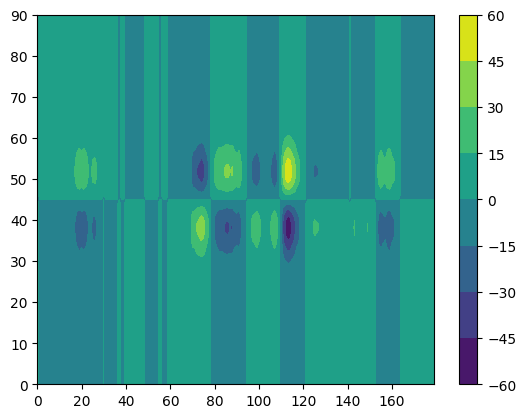

In [16]:
plt.contourf(olr_re1[0,:,:].squeeze())
plt.colorbar()

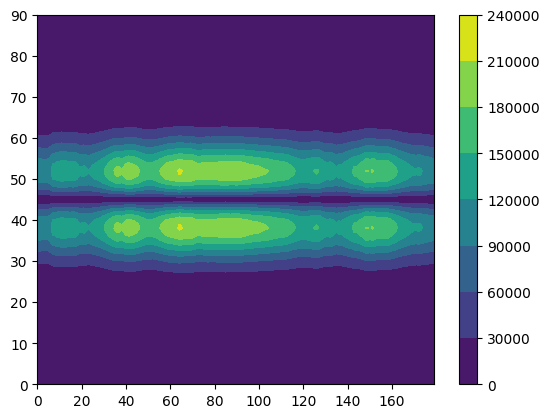

In [17]:
plt.contourf(np.sum(np.absolute(olr_re1), axis=0))
plt.colorbar()